# Hackathon Dauphine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, tree, metrics
from sklearn.metrics import roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier

pd.set_option('display.max_columns', 100)
%matplotlib inline

C:\Users\axeld\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\axeld\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\axeld\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\axeld\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

### Load Data

In [2]:
X = pd.read_csv('data/ref_phase2_train_x.csv').drop('raw_id', axis = 1)
Y = pd.read_csv('data/ref_phase2_train_y.csv', header = None, names = ['Y'])
data = pd.concat([X, Y], axis = 1)

X_test = pd.read_csv('data/ref_phase2_valid_x.csv').drop('raw_id', axis = 1)

# Explore Data

In [3]:
data.head()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov,Y
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,57.83,55.47,46.20,0
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,58.41,55.24,49.96,0
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,57.15,53.86,53.23,0
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581,58.28,53.79,54.67,0
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581,57.88,53.49,54.43,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 26 columns):
sector                    19440 non-null int64
earnings_implied_obs      19418 non-null float64
delta_vol_1w              19430 non-null float64
delta_vol_1y              19151 non-null float64
return_1w                 19439 non-null float64
return_1m                 19439 non-null float64
return_1y                 19439 non-null float64
implied_vol_3m            19435 non-null float64
realised_vol_1w           19437 non-null float64
realised_vol_1m           19437 non-null float64
realised_vol_1y           19438 non-null float64
ratio_put_call            19327 non-null float64
publication_date_funda    19413 non-null float64
exchange                  19440 non-null object
net_income                19411 non-null float64
shareholders_equity       19406 non-null float64
net_debt                  19408 non-null float64
ebitda                    16992 non-null float64
ebit        

In [5]:
data.describe()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov,Y
count,19440.000000,19418.000000,19430.000000,19151.000000,19439.000000,19439.000000,19439.000000,19435.000000,19437.000000,19437.000000,19438.000000,19327.000000,19413.000000,19411.000000,19406.000000,19408.000000,16992.000000,16996.000000,19410.000000,19399.000000,19322.000000,19254.000000,19254.000000,19254.000000,19440.000000
mean,3028.526235,4.098524,0.210169,0.549865,0.251933,1.493478,13.565850,26.827969,1.444830,1.496241,1.678772,0.483964,206.325813,0.035468,0.491910,0.627380,0.133534,0.084255,0.959154,0.116052,72.459198,58.887032,58.620781,51.464068,0.267798
std,1324.685363,2.430456,3.457583,9.356610,3.641251,7.232626,25.300613,9.933363,0.810105,0.793104,0.672269,0.153866,108.650566,0.427005,0.516871,3.554806,0.139489,0.103607,1.375381,0.292905,568.572416,12.802463,8.179286,11.337379,0.442823
min,1100.000000,0.034300,-102.059100,-297.204800,-102.875600,-50.447900,-186.668800,5.070000,0.141037,0.128684,0.495623,0.000070,3.000000,-53.872876,-16.984842,-10.718349,-5.507148,-6.746918,-0.186518,-1.730255,0.000000,24.640000,34.420000,14.720000,0.000000
25%,2100.000000,2.769000,-0.752300,-2.830650,-1.563000,-2.566150,-0.062750,20.998350,0.944776,1.044786,1.241442,0.395472,122.000000,0.028640,0.203421,0.021878,0.070484,0.049797,0.300651,0.055481,18.253968,51.152500,52.780000,43.812500,0.000000
50%,3200.000000,3.642000,0.056900,0.719600,0.398100,1.662000,14.288800,24.881700,1.280953,1.347524,1.520639,0.487549,211.000000,0.046360,0.358469,0.155914,0.103089,0.073148,0.561632,0.084235,36.641221,61.060000,59.130000,52.355000,0.000000
75%,4700.000000,4.839600,1.007075,4.065150,2.216950,5.672450,28.226300,30.208700,1.742697,1.754616,1.935633,0.575376,324.000000,0.067928,0.639400,0.433521,0.159945,0.104700,1.108054,0.136602,60.144928,68.350000,64.610000,59.820000,1.000000
max,6000.000000,96.156200,297.876900,288.698800,49.581700,103.039800,276.248400,329.046700,26.094069,38.178429,15.267396,0.999917,931.000000,0.888207,19.549657,362.873617,5.016946,4.711881,33.675033,36.050037,40483.870968,90.040000,80.820000,82.110000,1.000000


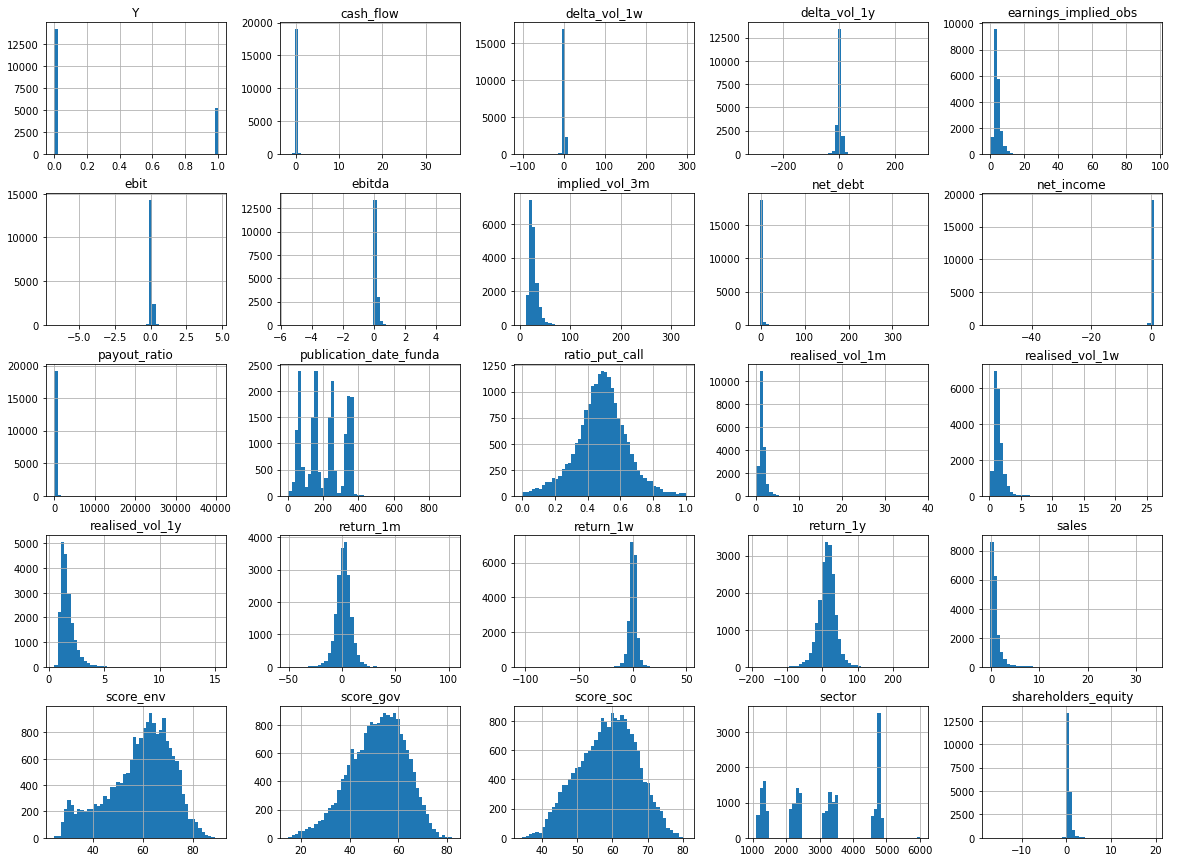

In [6]:
#Projection des données globales :
data.hist(bins=50, figsize=(20,15))
plt.savefig("images/figure.png")
plt.show()
#Image(url= "images/figure.png")

<div class="alert alert-info">
We can see that there is not any real outliers, our dataset was cleaned for the Hackathon.  
However, the real important insight that we can clearly see is that even though it's encoded as int, **sector** is in reality a **categorical feature**.  
  
Even more, there seems to be a **big sector**, encoded as the thousands number. We're going to add to this information to the dataset, by one hot encoding for the big_sector, and leave the sectors as they are so that we can still see the proximity relation between them.

### Fill NaNs with KNN imputer

In [7]:
from sklearn.impute import KNNImputer
def fill_na(df, knn=10):
    df_num = df[list(df.describe())]
    
    columns_full = list(df)
    columns_numerical = list(df_num)
    columns_categorical = [x for x in columns_full if x not in columns_numerical]
    df_categorical = df[columns_categorical]

    imputer = KNNImputer(n_neighbors=5)
    df_num_treated = imputer.fit_transform(df_num)
    df_num_treated = pd.DataFrame(df_num_treated, columns = columns_numerical)
    
    df_full_treated = pd.concat([df_num_treated, df_categorical], axis=1)[columns_full]
    return(df_full_treated)

### Create Big Sector feature

In [8]:
data['big_sector'] = data['sector'] // 1000
X_test['big_sector'] = X_test['sector'] // 1000

In [9]:
data['big_sector'] = [str(x) for x in data['big_sector']]
X_test['big_sector'] = [str(x) for x in X_test['big_sector']]

### One-Hot encode categorical Features (exchange (US, EU), big_sector) 

In [10]:
import category_encoders as ce
def encode(df):
    encoder = ce.OneHotEncoder(cols=['big_sector'])
    df = encoder.fit_transform(df)
    
    le = preprocessing.LabelEncoder()
    le_exchange = le.fit_transform(df['exchange'])
    df['exchange'] = le_exchange
    return df

In [11]:
data = encode(data)
X_test = encode(X_test)

# Create Financial features :

In [12]:
def create_features(df):
    df['return_1y_1m'] = df.return_1y - df.return_1m
    df['return_1m_1w'] = df.return_1m - df.return_1w
    
    #Sharpe 1w, 1m, 1y
    df['sharpe_1w'] = df.return_1w / df.realised_vol_1w
    df['sharpe_1m'] = df.return_1m / df.realised_vol_1m
    df['sharpe_1y'] = df.return_1y / df.realised_vol_1y
    
    #Normalized ESG score by Sector
    df['score_env_sect'] = df.groupby('sector')['score_env'].transform(lambda grp: grp.mean())
    df['score_soc_sect'] = df.groupby('sector')['score_soc'].transform(lambda grp: grp.mean())
    df['score_gov_sect'] = df.groupby('sector')['score_gov'].transform(lambda grp: grp.mean())
    
    df['score_env_ratio'] = df['score_env'] / df['score_env_sect']
    df['score_soc_ratio'] = df['score_soc'] / df['score_soc_sect']
    df['score_gov_ratio'] = df['score_gov'] / df['score_gov_sect']
    
    #Normalized Put/Call Ratio by Sector
    df['ratio_put_call_sect'] = df.groupby('sector')['ratio_put_call'].transform(lambda grp: grp.mean())
    df['ratio_put_call_norm'] = df['ratio_put_call'] / df['ratio_put_call_sect']

    df['vol_sub_1w'] = df['implied_vol_3m'] - df['realised_vol_1w']*np.sqrt(52)
    df['vol_sub_1m'] = df['implied_vol_3m'] - df['realised_vol_1m']*np.sqrt(12)
    df['vol_sub_1y'] = df['implied_vol_3m'] - df['realised_vol_1y']

    #Normalized ESG Score by Zone (Exchange~Zone because exchange=US or EU)
    df['score_env_zone'] = df.groupby('exchange')['score_env'].transform(lambda grp: grp.mean())
    df['score_soc_zone'] = df.groupby('exchange')['score_soc'].transform(lambda grp: grp.mean())
    df['score_gov_zone'] = df.groupby('exchange')['score_gov'].transform(lambda grp: grp.mean())

    df['score_env_zone_ratio'] = df['score_env'] / df['score_env_zone']
    df['score_soc_zone_ratio'] = df['score_soc'] / df['score_soc_zone']
    df['score_gov_zone_ratio'] = df['score_gov'] / df['score_gov_zone']

    #Normalized Put/Call Ratio by Zone
    df['ratio_put_call_zone'] = df.groupby('exchange')['ratio_put_call'].transform(lambda grp: grp.mean())
    df['ratio_put_call_zone_norm'] = df['ratio_put_call'] / df['ratio_put_call_zone']
    return df

In [13]:
data = create_features(data)
x_test = create_features(X_test)

In [14]:
data.head()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov,Y,big_sector_1,big_sector_2,big_sector_3,big_sector_4,big_sector_5,return_1y_1m,return_1m_1w,sharpe_1w,sharpe_1m,sharpe_1y,score_env_sect,score_soc_sect,score_gov_sect,score_env_ratio,score_soc_ratio,score_gov_ratio,ratio_put_call_sect,ratio_put_call_norm,vol_sub_1w,vol_sub_1m,vol_sub_1y,score_env_zone,score_soc_zone,score_gov_zone,score_env_zone_ratio,score_soc_zone_ratio,score_gov_zone_ratio,ratio_put_call_zone,ratio_put_call_zone_norm
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,1,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,57.83,55.47,46.20,0,1,0,0,0,0,20.9545,-1.0880,2.840812,1.300077,15.769477,65.342577,60.653185,50.539653,0.885028,0.914544,0.914134,0.438464,1.177251,11.491742,14.108517,15.769705,56.122558,56.156125,52.647325,1.030423,0.987782,0.877537,0.457142,1.129150
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,1,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,58.41,55.24,49.96,0,1,0,0,0,0,16.2463,-1.9590,3.524559,1.621503,12.836966,65.342577,60.653185,50.539653,0.893904,0.910752,0.988531,0.438464,1.231682,9.180686,13.066615,14.581585,56.122558,56.156125,52.647325,1.040758,0.983686,0.948956,0.457142,1.181358
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,1,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,57.15,53.86,53.23,0,1,0,0,0,0,8.6225,-1.6627,-0.717106,-3.291033,6.913892,65.342577,60.653185,50.539653,0.874621,0.888000,1.053232,0.438464,1.274354,9.536656,13.984360,15.552028,56.122558,56.156125,52.647325,1.018307,0.959112,1.011068,0.457142,1.222287
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,1,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581,58.28,53.79,54.67,0,1,0,0,0,0,3.9902,3.9104,3.162061,9.262388,10.819748,65.342577,60.653185,50.539653,0.891915,0.886845,1.081725,0.438464,1.821004,12.325125,13.895145,15.075289,56.122558,56.156125,52.647325,1.038442,0.957865,1.038419,0.457142,1.746601
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,1,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581,57.88,53.49,54.43,0,1,0,0,0,0,13.0073,3.0350,1.506314,4.487216,19.930063,65.342577,60.653185,50.539653,0.885793,0.881899,1.076976,0.438464,1.581471,7.582174,10.968542,13.536575,56.122558,56.156125,52.647325,1.031314,0.952523,1.033861,0.457142,1.516855


### Train/Test sets

In [15]:
X = data.drop('Y', axis = 1)
y = data['Y']
X = fill_na(X)
X_test = fill_na(X_test)

# Model & Grid Search

<div class="alert alert-info">
We chose a Balanced random Forest because XGBoost overfits a lot, as the dataset is unbalanced, there is about 25% of 1s, and 75% of 0s, so it would put a lot of weight on the errors of the 0s, more than for the 1s.  
That's why we adopted the BalancedRandomForest.

In [16]:
# RF_B_Tuned = BalancedRandomForestClassifier(n_jobs = -1, criterion= 'gini') 

# parameters = {'n_estimators': [10, 100, 500],
#               'min_samples_leaf': [1, 5, 10],
#               'max_depth': [None, 1, 15],
#               'max_features' : ['log2','sqrt']}

# GSCV = GridSearchCV(estimator = RF_B_Tuned,
#                            param_grid = parameters,
#                            scoring = 'roc_auc',
#                            cv = 5,
#                            n_jobs = -1)

# GSCV.fit(X, y)

### Predict & submission

In [17]:
#RF_B_optim = GSCV.best_estimator_
RF_B_optim = BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=15,
                               max_features='log2', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=5, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=500,
                               n_jobs=-1, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)
RF_B_optim = RF_B_optim.fit(X, y)

In [18]:
y_predict_optim = RF_B_optim.predict_proba(X_test)[:,1]

np.savetxt('submissions/MSDS_pred_final.csv', y_predict_optim, delimiter = ".")

### Model analysis

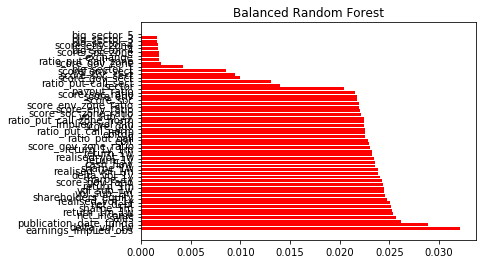

In [19]:
importances = RF_B_optim.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange features names so they match the sorted feature importances
names = [list(X)[i] for i in indices]

# Create plot
plt.figure()
plt.title("Balanced Random Forest")
plt.barh(range(X.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(X.shape[1]), names)

# Show plot
plt.show()